In [2]:
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from matplotlib import pyplot as plt

from grid_manager import MPC_op
from data_loader import UCSD_dataloader
from battery_model import Battery_base
from optimizer import Battery_optimizer
from predictor import *
from utils.plot_utils import *

customize_plt()

exp_suffix = "Mar2023"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
assert os.path.exists(exp_folder)

In [9]:
def df_filter(df, **kw):
    sig = None
    for k in kw.keys():
        if sig is None:
            sig = df[k] == kw[k]
        else:
            sig = sig & (df[k] == kw[k])
    return df.loc[sig]


def read_df(fn, **kw):
    df = pd.read_excel(fn, index_col=0)
    return df_filter(df, **kw).copy()


def get_identifier(df, cols, col_name=True):
    def lambda_id(x):
        s = ""
        for c in cols:
            if col_name:
                s += f"_{c}-{x[c]}"
            else:
                s += f"_{x[c]}"
        return s[1:]
    return df.apply(lambda_id, axis=1)

In [10]:
log_fn = "EnS_EV_log.xlsx"
log_df = read_df(os.path.join(exp_folder, log_fn), K=20)

In [11]:
idx = get_identifier(log_df, ["incl_ev", "ev_how_to", "ev_to_bld"], col_name=False)
log_df.index = idx

In [14]:
idx

id
1      True_None_0.25
2      True_unif_0.25
3      True_asap_0.25
4     False_None_0.25
9       True_None_0.5
10      True_unif_0.5
11      True_asap_0.5
12     False_None_0.5
13     True_None_0.75
14     True_unif_0.75
15     True_asap_0.75
16    False_None_0.75
17      True_None_1.0
18      True_unif_1.0
19      True_asap_1.0
20     False_None_1.0
dtype: object

In [28]:
ev_ratios = np.arange(0.25, 1.1, 0.25)
rules = ["False_None", "True_None", "True_unif", "True_asap", ]

res = {rule: {} for rule in rules}

for rule in rules:
    idx = ["{}_{}".format(rule, r) for r in ev_ratios]
    res[rule]["eq_bat_capacity"] =  log_df.loc[idx, "eq_bat_capacity"].values
    res[rule]["eq_rate"] =  log_df.loc[idx, "eq_rate"].values

In [24]:
rule_names = {
    "True_None": "Null", 
    "True_unif": "UNIF", 
    "True_asap": "ASAP", 
    "False_None": "excl. EV"
}

rule_colors = {
    "True_None": "royalblue",
    "True_unif": "goldenrod",
    "True_asap": "tomato",
    "False_None": "silver"
}

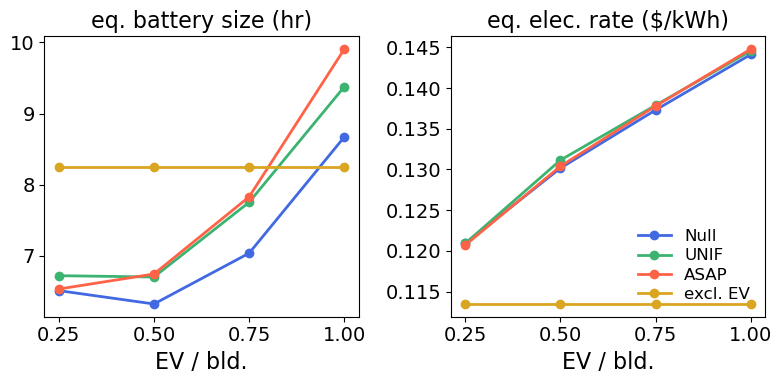

In [19]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

for i in range(2):
    ax = axs[i]
    key = "eq_bat_capacity" if i == 0 else "eq_rate"
    ylabel = "eq. battery size (hr)" if i == 0 else "eq. elec. rate ($/kWh)"

    for rule in rules:
        ax.plot(ev_ratios, res[rule][key], "o-", c=rule_colors[rule], label=rule_names[rule])
    
    if i == 1:
        ax.legend(loc="lower right", handlelength=2)
        # ax.yaxis.set_label_position("right")
        # ax.yaxis.tick_right()

    ax.set_xticks(ev_ratios)
    ax.set_xlabel("EV / bld.")

    ax.set_title(ylabel)

plt.tight_layout()
# plt.savefig("214-fig5-EV_bat.png", dpi=300, facecolor="w", bbox_inches="tight")


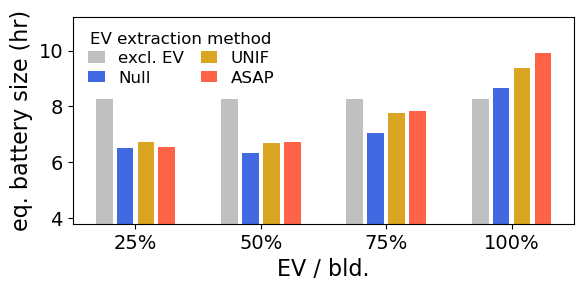

In [43]:
fig, ax = plt.subplots(figsize=(6, 3))

key = "eq_bat_capacity"
ylabel = "eq. battery size (hr)"

for j in range(len(rules)):
    rule = rules[j]
    x = np.arange(j, j + 4*6,6)
    ax.bar(x, res[rule][key], color=rule_colors[rule], label=rule_names[rule])
ax.set_ylim(3.8, 11.2)
ax.legend(loc="upper left", ncol=2, title="EV extraction method")

ax.set_ylabel(ylabel)
ax.set_xlabel("EV / bld.")
ax.set_xticks(np.arange(1.5, 1.5+24, 6))
ax.set_xticklabels(["{:.0%}".format(x) for x in np.arange(0.25, 1.1, 0.25)])

plt.tight_layout()
plt.savefig("358-fig6-EV.png", dpi=300, facecolor="w", bbox_inches="tight")